# Clustering (taking into account the pre-calculated Clusters)

## 1. Import Libraries

In [1]:
# Import Libraries
%matplotlib inline
import pandas as pd
import numpy as np

# não sei porque é que os comandos abaixo são necessários, mas eliminam mensagens de erro do geopandas
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

import matplotlib.pyplot as plt
import contextily as cx

from geopandas import GeoDataFrame
from shapely.geometry import Point
import statsmodels.api as sm

from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran_bv
import mapclassify as mc
from pysal.model import spreg
import spopt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise as skm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import davies_bouldin_score

import scipy.cluster.hierarchy as sch

from spopt.region import MaxPHeuristic as MaxP
from libpysal.weights import Queen

import scipy.sparse as sp
from splot.libpysal import plot_spatial_weights


/Users/andresilvalima/miniforge3/envs/Thesis/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/andresilvalima/miniforge3/envs/Thesis/lib/python3.11/site-packages/quantecon/lss.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/andresilvalima/miniforge3/envs/Thesis/lib/python3.11/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of

## 2. Loading Data, Transforming Variables

In [2]:
# read data
bgri_cluster = pd.read_pickle('../Data/piclo_bgri.piclo')

In [3]:
all_data = pd.read_pickle('../Data/all_data.piclo')

In [4]:
bgri_cluster.shape

(499, 125)

In [5]:
bgri_cluster.shape

(499, 125)

In [6]:
# read data
clusters_fr = pd.read_pickle('../Data/piclo_clusters_fr.piclo')
clusters_lug = pd.read_pickle('../Data/piclo_clusters_lug.piclo')
clusters_lp = pd.read_pickle('../Data/piclo_clusters_lp.piclo')

In [7]:
bgri_cluster.head()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,N_EDIFICIOS_PRINCIP_NAO_RESID,...,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FR11,LUG11,Cluster_LP
0,6,0,0,0,0,6,0,2,4,0,...,17,29,0,10,48,25,46,01,014757,30
1,2,0,0,0,0,2,0,1,1,0,...,5,14,1,14,37,19,29,01,014757,124
2,14,2,1,1,0,12,0,6,8,0,...,6,11,0,11,43,14,36,01,014757,124
3,4,0,0,0,0,4,0,0,4,0,...,10,21,1,5,36,12,30,01,014757,3
4,13,11,7,4,0,2,0,13,0,0,...,15,26,0,10,71,21,60,01,014757,58


In [8]:
bgri_cluster.shape

(499, 125)

In [9]:
bgri_cluster[bgri_cluster['Cluster_LP'].isnull()]

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,N_EDIFICIOS_PRINCIP_NAO_RESID,...,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FR11,LUG11,Cluster_LP
50,12,12,5,2,5,0,0,12,0,0,...,10,10,0,3,2,0,4,01,014757,<NA>


In [10]:
bgri_cluster=bgri_cluster[~bgri_cluster['Cluster_LP'].isnull()]

In [11]:
bgri_cluster.shape

(498, 125)

In [12]:
clusters_fr.head()

,FR11,geometry,area
0,01,"POLYGON ((-43425.018 105292.668, -43469.109 10...",0.141979
1,05,"POLYGON ((-42234.961 107994.437, -42243.784 10...",0.055570
2,06,"POLYGON ((-43906.302 106508.920, -43914.801 10...",0.047657
3,10,"POLYGON ((-41907.078 105291.591, -41922.768 10...",0.049197
4,12,"POLYGON ((-44088.695 108184.616, -44154.064 10...",0.093782


In [13]:
clusters_lug.head()

,LUG11,geometry,area
0,014757,"POLYGON ((-43858.355 106177.760, -43870.452 10...",0.141979


In [14]:
clusters_lp.head()

,Cluster_LP,geometry,area
0,3.0,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286
1,5.0,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979
2,13.0,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570
3,14.0,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652
4,18.0,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896


In [15]:
clusters_fr.shape

(6, 3)

In [16]:
clusters_lug.shape

(1, 3)

In [17]:
clusters_lp.shape

(74, 3)

In [18]:
bgri_cluster.head()

,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,N_EDIFICIOS_PRINCIP_NAO_RESID,...,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FR11,LUG11,Cluster_LP
0,6,0,0,0,0,6,0,2,4,0,...,17,29,0,10,48,25,46,01,014757,30
1,2,0,0,0,0,2,0,1,1,0,...,5,14,1,14,37,19,29,01,014757,124
2,14,2,1,1,0,12,0,6,8,0,...,6,11,0,11,43,14,36,01,014757,124
3,4,0,0,0,0,4,0,0,4,0,...,10,21,1,5,36,12,30,01,014757,3
4,13,11,7,4,0,2,0,13,0,0,...,15,26,0,10,71,21,60,01,014757,58


In [19]:
bgri_cluster.shape

(498, 125)

In [20]:
# group by cluster and sum values, getting socioeconomic indicators for each cluster (from the subsection information)
bgri_cluster_LP = bgri_cluster.groupby(["Cluster_LP"]).sum().reset_index(level='Cluster_LP')
bgri_cluster_LUG = bgri_cluster.groupby(["LUG11"]).sum().reset_index(level='LUG11')
bgri_cluster_FR = bgri_cluster.groupby(["FR11"]).sum().reset_index(level='FR11')

In [21]:
bgri_cluster_LP.shape

(74, 125)

In [22]:
# rotinas utilizadas para verificar a presença de NaNs - linhas dropadas

# set de pontos (X) com NaNs depois do standardscaler()
# este output só aparece se o bloco "bgri_cluster.drop([24, 32, 47, 94, 101], axis=0, inplace=True)" não estiver implementado


# {10, 14, 49, 56, 59, 61, 62}



In [23]:
bgri_cluster_LP.isnull().values.any()

False

In [24]:
list(bgri_cluster_LP.columns)

['Cluster_LP',
 'N_EDIFICIOS_CLASSICOS',
 'N_EDIFICIOS_CLASSICOS_1OU2',
 'N_EDIFICIOS_CLASSICOS_ISOLADOS',
 'N_EDIFICIOS_CLASSICOS_GEMIN',
 'N_EDIFICIOS_CLASSICOS_EMBANDA',
 'N_EDIFICIOS_CLASSICOS_3OUMAIS',
 'N_EDIFICIOS_CLASSICOS_OUTROS',
 'N_EDIFICIOS_EXCLUSIV_RESID',
 'N_EDIFICIOS_PRINCIPAL_RESID',
 'N_EDIFICIOS_PRINCIP_NAO_RESID',
 'N_EDIFICIOS_1OU2_PISOS',
 'N_EDIFICIOS_3OU4_PISOS',
 'N_EDIFICIOS_5OU_MAIS_PISOS',
 'N_EDIFICIOS_CONSTR_ANTES_1919',
 'N_EDIFICIOS_CONSTR_1919A1945',
 'N_EDIFICIOS_CONSTR_1946A1960',
 'N_EDIFICIOS_CONSTR_1961A1970',
 'N_EDIFICIOS_CONSTR_1971A1980',
 'N_EDIFICIOS_CONSTR_1981A1990',
 'N_EDIFICIOS_CONSTR_1991A1995',
 'N_EDIFICIOS_CONSTR_1996A2000',
 'N_EDIFICIOS_CONSTR_2001A2005',
 'N_EDIFICIOS_CONSTR_2006A2011',
 'N_EDIFICIOS_ESTRUT_BETAO',
 'N_EDIFICIOS_ESTRUT_COM_PLACA',
 'N_EDIFICIOS_ESTRUT_SEM_PLACA',
 'N_EDIFICIOS_ESTRUT_ADOBE_PEDRA',
 'N_EDIFICIOS_ESTRUT_OUTRA',
 'N_ALOJAMENTOS',
 'N_ALOJAMENTOS_FAMILIARES',
 'N_ALOJAMENTOS_FAM_CLASSICOS',
 'N_ALOJA

In [25]:
## code below was used to check for NaNs in the rows identified with NaN values
# bgri_cluster_LP.loc[[10]].transpose()[0:60]
# bgri_cluster_LP.loc[[14]].transpose()[0:60]
# bgri_cluster_LP.loc[[49]].transpose()[0:60]
# bgri_cluster_LP.loc[[56]].transpose()[0:60]
# bgri_cluster_LP.loc[[61]].transpose()[0:60]
# bgri_cluster_LP.loc[[62]].transpose()[0:60]

In [26]:
## after analyzing all the columns, we decided to drop the following columns:
## - N_RES_HABITUAL_1_2_DIV
## - N_RES_HABITUAL_3_4_DIV
## - N_RES_HABITUAL_ESTAC_1
## - N_RES_HABITUAL_ESTAC_2
## - N_RES_HABITUAL_ESTAC_3

In [27]:
bgri_cluster_LP.drop(columns=['N_RES_HABITUAL_1_2_DIV','N_RES_HABITUAL_3_4_DIV','N_RES_HABITUAL_ESTAC_1','N_RES_HABITUAL_ESTAC_2','N_RES_HABITUAL_ESTAC_3'], inplace=True)

In [28]:
## drop row with ONLY NaNs - other 6 rows with NaNs were not dropped; columns with NaN values were dropped instead
# bgri_cluster_LP.drop([61], axis=0, inplace=True)

In [29]:
bgri_cluster_LP.head()

,Cluster_LP,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_EMPREGADOS,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FR11,LUG11
0,3,54,19,9,0,10,35,0,37,17,...,247,160,256,1,41,205,105,194,01010101010101,014757014757014757014757014757014757014757
1,5,508,458,229,98,131,41,9,487,15,...,775,327,538,9,197,569,292,605,0101010101010101010101010101010101010101010101...,0147570147570147570147570147570147570147570147...
2,13,43,31,17,7,7,9,3,40,1,...,97,40,62,1,29,67,38,79,10,014757
3,14,53,27,1,26,0,26,0,48,5,...,193,83,174,0,37,156,96,157,050505,014757014757014757
4,18,47,8,2,0,6,39,0,38,9,...,403,142,268,0,83,320,166,313,05050505,014757014757014757014757


### 2.1 New variables, enhancing the information available in the dataset

In [30]:
# here we prove that N_EDIFICIOS_CLASSICOS_ISOLADOS+N_EDIFICIOS_CLASSICOS_GEMIN+N_EDIFICIOS_CLASSICOS_EMBANDA=N_EDIFICIOS_CLASSICOS_1OU2
bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_1OU2'].sum()==(bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_ISOLADOS']+bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_GEMIN']+bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_EMBANDA']).sum()

True

In [31]:
# here we prove that N_EDIFICIOS_CLASSICOS_ISOLADOS+N_EDIFICIOS_CLASSICOS_GEMIN+N_EDIFICIOS_CLASSICOS_EMBANDA=N_EDIFICIOS_CLASSICOS_1OU2
bgri_cluster_LUG['N_EDIFICIOS_CLASSICOS_1OU2'].sum()==(bgri_cluster_LUG['N_EDIFICIOS_CLASSICOS_ISOLADOS']+bgri_cluster_LUG['N_EDIFICIOS_CLASSICOS_GEMIN']+bgri_cluster_LUG['N_EDIFICIOS_CLASSICOS_EMBANDA']).sum()

True

In [32]:
# here we prove that N_EDIFICIOS_CLASSICOS_ISOLADOS+N_EDIFICIOS_CLASSICOS_GEMIN+N_EDIFICIOS_CLASSICOS_EMBANDA=N_EDIFICIOS_CLASSICOS_1OU2
bgri_cluster_FR['N_EDIFICIOS_CLASSICOS_1OU2'].sum()==(bgri_cluster_FR['N_EDIFICIOS_CLASSICOS_ISOLADOS']+bgri_cluster_FR['N_EDIFICIOS_CLASSICOS_GEMIN']+bgri_cluster_FR['N_EDIFICIOS_CLASSICOS_EMBANDA']).sum()

True

In [33]:
bgri_cluster_LP.head()

,Cluster_LP,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_EMPREGADOS,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FR11,LUG11
0,3,54,19,9,0,10,35,0,37,17,...,247,160,256,1,41,205,105,194,01010101010101,014757014757014757014757014757014757014757
1,5,508,458,229,98,131,41,9,487,15,...,775,327,538,9,197,569,292,605,0101010101010101010101010101010101010101010101...,0147570147570147570147570147570147570147570147...
2,13,43,31,17,7,7,9,3,40,1,...,97,40,62,1,29,67,38,79,10,014757
3,14,53,27,1,26,0,26,0,48,5,...,193,83,174,0,37,156,96,157,050505,014757014757014757
4,18,47,8,2,0,6,39,0,38,9,...,403,142,268,0,83,320,166,313,05050505,014757014757014757014757


In [34]:
bgri_cluster_LP.shape

(74, 120)

In [35]:
# sabemos que N_EDIFICIOS_CLASSICOS = N_EDIFICIOS_CLASSICOS_ISOLADOS + N_EDIFICIOS_CLASSICOS_GEMIN + N_EDIFICIOS_CLASSICOS_EMBANDA + 
# + N_EDIFICIOS_CLASSICOS_3OUMAIS + N_EDIFICIOS_CLASSICOS_OUTROS

# drop possivel - N_EDIFICIOS_CLASSICOS_OUTROS (para não dar 100%)

bgri_cluster_LP['PER_EDIFICIOS_CLASSICOS_ISOLADOS']=bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_ISOLADOS']/bgri_cluster_LP['N_EDIFICIOS_CLASSICOS']
bgri_cluster_LP['PER_EDIFICIOS_CLASSICOS_GEMIN']=bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_GEMIN']/bgri_cluster_LP['N_EDIFICIOS_CLASSICOS']
bgri_cluster_LP['PER_EDIFICIOS_CLASSICOS_EMBANDA']=bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_EMBANDA']/bgri_cluster_LP['N_EDIFICIOS_CLASSICOS']
bgri_cluster_LP['PER_EDIFICIOS_CLASSICOS_1OU2']=bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_1OU2']/bgri_cluster_LP['N_EDIFICIOS_CLASSICOS']
bgri_cluster_LP['PER_EDIFICIOS_CLASSICOS_3OUMAIS']=bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_3OUMAIS']/bgri_cluster_LP['N_EDIFICIOS_CLASSICOS']
bgri_cluster_LP['PER_EDIFICIOS_CLASSICOS_OUTROS']=bgri_cluster_LP['N_EDIFICIOS_CLASSICOS_OUTROS']/bgri_cluster_LP['N_EDIFICIOS_CLASSICOS']

bgri_cluster_LP.drop(['N_EDIFICIOS_CLASSICOS','N_EDIFICIOS_CLASSICOS_1OU2', 'N_EDIFICIOS_CLASSICOS_ISOLADOS','N_EDIFICIOS_CLASSICOS_GEMIN',
                   'N_EDIFICIOS_CLASSICOS_EMBANDA','N_EDIFICIOS_CLASSICOS_3OUMAIS','N_EDIFICIOS_CLASSICOS_OUTROS'], axis=1, inplace=True)

In [36]:
# sabemos que N_EDIFICIOS_EXCLUSIV_RESID + N_EDIFICIOS_PRINCIPAL_RESID + N_EDIFICIOS_PRINCIP_NAO_RESID =
# = N_EDIFICIOS_1OU2_PISOS + N_EDIFICIOS_3OU4_PISOS + N_EDIFICIOS_5OU_MAIS_PISOS

# drop possivel - PER_EDIFICIOS_5OU_MAIS_PISOS (para não dar 100%)

bgri_cluster_LP['total_temp']=bgri_cluster_LP['N_EDIFICIOS_EXCLUSIV_RESID']+bgri_cluster_LP['N_EDIFICIOS_PRINCIPAL_RESID']+bgri_cluster_LP['N_EDIFICIOS_PRINCIP_NAO_RESID']

bgri_cluster_LP['PER_EDIFICIOS_EXCLUSIV_RESID']=bgri_cluster_LP['N_EDIFICIOS_EXCLUSIV_RESID']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_PRINCIPAL_RESID']=bgri_cluster_LP['N_EDIFICIOS_PRINCIPAL_RESID']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_PRINCIP_NAO_RESID']=bgri_cluster_LP['N_EDIFICIOS_PRINCIP_NAO_RESID']/bgri_cluster_LP['total_temp']

bgri_cluster_LP['PER_EDIFICIOS_1OU2_PISOS']=bgri_cluster_LP['N_EDIFICIOS_1OU2_PISOS']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_3OU4_PISOS']=bgri_cluster_LP['N_EDIFICIOS_3OU4_PISOS']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_5OU_MAIS_PISOS']=bgri_cluster_LP['N_EDIFICIOS_5OU_MAIS_PISOS']/bgri_cluster_LP['total_temp']

bgri_cluster_LP.drop(['total_temp','N_EDIFICIOS_EXCLUSIV_RESID','N_EDIFICIOS_PRINCIPAL_RESID','N_EDIFICIOS_PRINCIP_NAO_RESID',
                   'N_EDIFICIOS_1OU2_PISOS','N_EDIFICIOS_3OU4_PISOS','N_EDIFICIOS_5OU_MAIS_PISOS'], axis=1, inplace=True)

In [37]:
# conversão dos indicadores do ano de construção em percentagens do total de casas

# drop possivel - N_EDIFICIOS_CONSTR_2006A2011 (para não dar 100%)

bgri_cluster_LP['total_temp']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_ANTES_1919']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1919A1945']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1946A1960']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1961A1970']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1971A1980']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1981A1990']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1991A1995']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_1996A2000']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_2001A2005']+bgri_cluster_LP['N_EDIFICIOS_CONSTR_2006A2011']

bgri_cluster_LP['PER_EDIFICIOS_CONSTR_ANTES_1919']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_ANTES_1919']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1919A1945']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1919A1945']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1946A1960']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1946A1960']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1961A1970']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1961A1970']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1971A1980']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1971A1980']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1981A1990']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1981A1990']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1991A1995']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1991A1995']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_1996A2000']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_1996A2000']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_2001A2005']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_2001A2005']/bgri_cluster_LP['total_temp']
bgri_cluster_LP['PER_EDIFICIOS_CONSTR_2006A2011']=bgri_cluster_LP['N_EDIFICIOS_CONSTR_2006A2011']/bgri_cluster_LP['total_temp']

bgri_cluster_LP.drop(['total_temp','N_EDIFICIOS_CONSTR_ANTES_1919','N_EDIFICIOS_CONSTR_1919A1945','N_EDIFICIOS_CONSTR_1946A1960','N_EDIFICIOS_CONSTR_1961A1970','N_EDIFICIOS_CONSTR_1971A1980','N_EDIFICIOS_CONSTR_1981A1990','N_EDIFICIOS_CONSTR_1991A1995','N_EDIFICIOS_CONSTR_1996A2000','N_EDIFICIOS_CONSTR_2001A2005','N_EDIFICIOS_CONSTR_2006A2011'], axis=1, inplace=True)

In [38]:
# vamos agora droppar variáveis que decidimos não usar, por acreditarmos que não "informam" o modelo

bgri_cluster_LP.drop(['N_EDIFICIOS_ESTRUT_BETAO','N_EDIFICIOS_ESTRUT_COM_PLACA','N_EDIFICIOS_ESTRUT_SEM_PLACA','N_EDIFICIOS_ESTRUT_ADOBE_PEDRA','N_EDIFICIOS_ESTRUT_OUTRA'], axis=1, inplace=True)

In [39]:
# "Cluster" de Variáveis em análise: N_ALOJAMENTOS, N_ALOJAMENTOS_FAM_CLASSICOS, N_ALOJAMENTOS_FAM_N_CLASSICOS, N_ALOJAMENTOS_COLECTIVOS, N_CLASSICOS_RES_HABITUAL, N_ALOJAMENTOS_RES_HABITUAL, N_ALOJAMENTOS_VAGOS
# Após análise (à parte), definiu-se que toda a informação destas variáveis está contida nos seguintes percentuais:

bgri_cluster_LP['PER_ALOJAMENTOS_FAM_CLASSICOS']=bgri_cluster_LP['N_ALOJAMENTOS_FAM_CLASSICOS']/bgri_cluster_LP['N_ALOJAMENTOS']
bgri_cluster_LP['PER_ALOJAMENTOS_FAM_N_CLASSICOS']=bgri_cluster_LP['N_ALOJAMENTOS_FAM_N_CLASSICOS']/bgri_cluster_LP['N_ALOJAMENTOS']
bgri_cluster_LP['PER_ALOJAMENTOS_COLECTIVOS']=bgri_cluster_LP['N_ALOJAMENTOS_COLECTIVOS']/bgri_cluster_LP['N_ALOJAMENTOS']
bgri_cluster_LP['PER_CLASSICOS_RES_HABITUAL']=bgri_cluster_LP['N_CLASSICOS_RES_HABITUAL']/bgri_cluster_LP['N_ALOJAMENTOS']
bgri_cluster_LP['PER_ALOJAMENTOS_RES_HABITUAL']=bgri_cluster_LP['N_ALOJAMENTOS_RES_HABITUAL']/bgri_cluster_LP['N_ALOJAMENTOS']
bgri_cluster_LP['PER_ALOJAMENTOS_VAGOS']=bgri_cluster_LP['N_ALOJAMENTOS_VAGOS']/bgri_cluster_LP['N_ALOJAMENTOS']
bgri_cluster_LP['PER_ALOJAMENTOS_FAMILIARES']=bgri_cluster_LP['N_ALOJAMENTOS_FAMILIARES']/bgri_cluster_LP['N_ALOJAMENTOS']

bgri_cluster_LP.drop(['N_ALOJAMENTOS', 'N_ALOJAMENTOS_FAM_CLASSICOS', 'N_ALOJAMENTOS_FAM_N_CLASSICOS', 'N_ALOJAMENTOS_COLECTIVOS', 'N_CLASSICOS_RES_HABITUAL', 'N_ALOJAMENTOS_RES_HABITUAL', 'N_ALOJAMENTOS_VAGOS','N_ALOJAMENTOS_FAMILIARES'], axis=1, inplace=True)

In [40]:
# vamos droppar as seguintes variáveis 'N_RES_HABITUAL_COM_AGUA','N_RES_HABITUAL_COM_RETRETE','N_RES_HABITUAL_COM_ESGOTOS','N_RES_HABITUAL_COM_BANHO'

bgri_cluster_LP.drop(['N_RES_HABITUAL_COM_AGUA','N_RES_HABITUAL_COM_RETRETE','N_RES_HABITUAL_COM_ESGOTOS','N_RES_HABITUAL_COM_BANHO'], axis=1, inplace=True)

In [41]:
# Próximo Cluster de 'N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200', 'N_RES_HABITUAL_AREA_200'

bgri_cluster_LP['temp_total']=bgri_cluster_LP['N_RES_HABITUAL_AREA_50']+bgri_cluster_LP['N_RES_HABITUAL_AREA_50_100']+bgri_cluster_LP['N_RES_HABITUAL_AREA_100_200']+bgri_cluster_LP['N_RES_HABITUAL_AREA_200']

bgri_cluster_LP['PER_RES_HABITUAL_AREA_50']=bgri_cluster_LP['N_RES_HABITUAL_AREA_50']/bgri_cluster_LP['temp_total']
bgri_cluster_LP['PER_RES_HABITUAL_AREA_50_100']=bgri_cluster_LP['N_RES_HABITUAL_AREA_50_100']/bgri_cluster_LP['temp_total']
bgri_cluster_LP['PER_RES_HABITUAL_AREA_100_200']=bgri_cluster_LP['N_RES_HABITUAL_AREA_100_200']/bgri_cluster_LP['temp_total']
bgri_cluster_LP['PER_RES_HABITUAL_AREA_200']=bgri_cluster_LP['N_RES_HABITUAL_AREA_200']/bgri_cluster_LP['temp_total']

bgri_cluster_LP.drop(['temp_total','N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200', 'N_RES_HABITUAL_AREA_200'], axis=1, inplace=True)

In [42]:
# Próximo Cluster de 'N_RES_HABITUAL_PROP_OCUP','N_RES_HABITUAL_ARREND'
# Não fui capaz de encontrar relação entre variáveis (os totais não batem certo), pelo que será criado subtotatal e as variáveis serão percentagens desses subtotais

bgri_cluster_LP['temp_total3']=bgri_cluster_LP['N_RES_HABITUAL_PROP_OCUP']+bgri_cluster_LP['N_RES_HABITUAL_ARREND']

bgri_cluster_LP['PER_RES_HABITUAL_PROP_OCUP']=bgri_cluster_LP['N_RES_HABITUAL_PROP_OCUP']/bgri_cluster_LP['temp_total3']
bgri_cluster_LP['PER_RES_HABITUAL_ARREND']=bgri_cluster_LP['N_RES_HABITUAL_ARREND']/bgri_cluster_LP['temp_total3']


bgri_cluster_LP.drop(['temp_total3','N_RES_HABITUAL_PROP_OCUP','N_RES_HABITUAL_ARREND'], axis=1, inplace=True)

In [43]:
# Próximo Cluster de 'N_FAMILIAS_CLASSICAS','N_FAMILIAS_INSTITUCIONAIS','N_FAMILIAS_CLASSICAS_1OU2_PESS','N_FAMILIAS_CLASSICAS_3OU4_PESS','N_FAMILIAS_CLASSICAS_NPES65',
                    #'N_FAMILIAS_CLASSICAS_NPES14','N_FAMILIAS_CLASSIC_SEM_DESEMP','N_FAMILIAS_CLASSIC_1DESEMPREG','N_FAMILIAS_CLASS_2MAIS_DESEMP'

# Não fui capaz de encontrar relação entre todas as variáveis (os totais não batem todos certo), pelo que serão as variáveis serão percentagens do N_FAMILIAS_CLASSICAS

bgri_cluster_LP['PER_FAMILIAS_INSTITUCIONAIS']=bgri_cluster_LP['N_FAMILIAS_INSTITUCIONAIS']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASSICAS_1OU2_PESS']=bgri_cluster_LP['N_FAMILIAS_CLASSICAS_1OU2_PESS']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASSICAS_3OU4_PESS']=bgri_cluster_LP['N_FAMILIAS_CLASSICAS_3OU4_PESS']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASSICAS_NPES65']=bgri_cluster_LP['N_FAMILIAS_CLASSICAS_NPES65']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASSICAS_NPES14']=bgri_cluster_LP['N_FAMILIAS_CLASSICAS_NPES14']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASSIC_SEM_DESEMP']=bgri_cluster_LP['N_FAMILIAS_CLASSIC_SEM_DESEMP']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASSIC_1DESEMPREG']=bgri_cluster_LP['N_FAMILIAS_CLASSIC_1DESEMPREG']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']
bgri_cluster_LP['PER_FAMILIAS_CLASS_2MAIS_DESEMP']=bgri_cluster_LP['N_FAMILIAS_CLASS_2MAIS_DESEMP']/bgri_cluster_LP['N_FAMILIAS_CLASSICAS']

bgri_cluster_LP.drop(['N_FAMILIAS_CLASSICAS','N_FAMILIAS_INSTITUCIONAIS','N_FAMILIAS_CLASSICAS_1OU2_PESS','N_FAMILIAS_CLASSICAS_3OU4_PESS','N_FAMILIAS_CLASSICAS_NPES65','N_FAMILIAS_CLASSICAS_NPES14','N_FAMILIAS_CLASSIC_SEM_DESEMP','N_FAMILIAS_CLASSIC_1DESEMPREG','N_FAMILIAS_CLASS_2MAIS_DESEMP'], axis=1, inplace=True)

In [44]:
# Próximo Cluster de 'N_NUCLEOS_FAMILIARES','N_NUCLEOS_1FILH_NAO_CASADO','N_NUCLEOS_2FILH_NAO_CASADO','N_NUCLEOS_FILH_INF_6ANOS','N_NUCLEOS_FILH_INF_15ANOS','N_NUCLEOS_FILH_MAIS_15ANOS'

# Não fui capaz de encontrar relação entre todas as variáveis (os totais não batem todos certo), pelo que serão as variáveis serão percentagens do N_NUCLEOS_FAMILIARES


bgri_cluster_LP['PER_NUCLEOS_1FILH_NAO_CASADO']=bgri_cluster_LP['N_NUCLEOS_1FILH_NAO_CASADO']/bgri_cluster_LP['N_NUCLEOS_FAMILIARES']
bgri_cluster_LP['PER_NUCLEOS_2FILH_NAO_CASADO']=bgri_cluster_LP['N_NUCLEOS_2FILH_NAO_CASADO']/bgri_cluster_LP['N_NUCLEOS_FAMILIARES']
bgri_cluster_LP['PER_NUCLEOS_FILH_INF_6ANOS']=bgri_cluster_LP['N_NUCLEOS_FILH_INF_6ANOS']/bgri_cluster_LP['N_NUCLEOS_FAMILIARES']
bgri_cluster_LP['PER_NUCLEOS_FILH_INF_15ANOS']=bgri_cluster_LP['N_NUCLEOS_FILH_INF_15ANOS']/bgri_cluster_LP['N_NUCLEOS_FAMILIARES']
bgri_cluster_LP['PER_NUCLEOS_FILH_MAIS_15ANOS']=bgri_cluster_LP['N_NUCLEOS_FILH_MAIS_15ANOS']/bgri_cluster_LP['N_NUCLEOS_FAMILIARES']

bgri_cluster_LP.drop(['N_NUCLEOS_FAMILIARES','N_NUCLEOS_1FILH_NAO_CASADO','N_NUCLEOS_2FILH_NAO_CASADO','N_NUCLEOS_FILH_INF_6ANOS','N_NUCLEOS_FILH_INF_15ANOS','N_NUCLEOS_FILH_MAIS_15ANOS'], axis=1, inplace=True)

In [45]:
# Antes de passarmos ao próximo bloco de indicadores a tratar, vamos eliminar todas as variáveis relativas ao sexo dos residentes, mantendo aoenas informação relativa à idade
bgri_cluster_LP.drop(['N_INDIVIDUOS_PRESENT_H','N_INDIVIDUOS_PRESENT_M','N_INDIVIDUOS_RESIDENT_H','N_INDIVIDUOS_RESIDENT_M','N_INDIVIDUOS_RESIDENT_H_0A4',
                   'N_INDIVIDUOS_RESIDENT_H_5A9','N_INDIVIDUOS_RESIDENT_H_10A13','N_INDIVIDUOS_RESIDENT_H_14A19','N_INDIVIDUOS_RESIDENT_H_15A19','N_INDIVIDUOS_RESIDENT_H_20A24',
                   'N_INDIVIDUOS_RESIDENT_H_20A64','N_INDIVIDUOS_RESIDENT_H_25A64','N_INDIVIDUOS_RESIDENT_H_65','N_INDIVIDUOS_RESIDENT_M_0A4','N_INDIVIDUOS_RESIDENT_M_5A9',
                   'N_INDIVIDUOS_RESIDENT_M_10A13','N_INDIVIDUOS_RESIDENT_M_14A19','N_INDIVIDUOS_RESIDENT_M_15A19','N_INDIVIDUOS_RESIDENT_M_20A24','N_INDIVIDUOS_RESIDENT_M_20A64',
                   'N_INDIVIDUOS_RESIDENT_M_25A64','N_INDIVIDUOS_RESIDENT_M_65'], axis=1, inplace=True)


In [46]:
# Próximo Cluster de 'N_INDIVIDUOS_PRESENT','N_INDIVIDUOS_RESIDENT','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19',
#                       'N_INDIVIDUOS_RESIDENT_15A19','N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65'

# Todos os indicadores acima serão calculados em percentagem da variável N_INDIVIDUOS_RESIDENT
# NOTA: esta variável N_INDIVIDUOS_RESIDENT não será dropada no final visto que ainda será necessária para o próximo batch de indicadores a tratar

bgri_cluster_LP['PER_INDIVIDUOS_PRESENT']=bgri_cluster_LP['N_INDIVIDUOS_PRESENT']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_0A4']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_0A4']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_5A9']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_5A9']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_10A13']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_10A13']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_14A19']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_14A19']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_20A24']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_20A24']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_25A64']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_25A64']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_INDIVIDUOS_RESIDENT_65']=bgri_cluster_LP['N_INDIVIDUOS_RESIDENT_65']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']

bgri_cluster_LP.drop(['N_INDIVIDUOS_PRESENT','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_15A19',
                   'N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65'], axis=1, inplace=True)

In [47]:
# Próximo Cluster de 'N_INDIVIDUOS_RESIDENT','N_INDIV_RESIDENT_N_LER_ESCRV','N_IND_RESIDENT_FENSINO_1BAS','N_IND_RESIDENT_FENSINO_2BAS','N_IND_RESIDENT_FENSINO_3BAS','N_IND_RESIDENT_FENSINO_SEC','N_IND_RESIDENT_FENSINO_POSSEC',
#'N_IND_RESIDENT_FENSINO_SUP','N_IND_RESIDENT_ENSINCOMP_1BAS','N_IND_RESIDENT_ENSINCOMP_2BAS','N_IND_RESIDENT_ENSINCOMP_3BAS','N_IND_RESIDENT_ENSINCOMP_SEC','N_IND_RESIDENT_ENSINCOMP_POSEC','N_IND_RESIDENT_ENSINCOMP_SUP',
#'N_IND_RESID_DESEMP_PROC_1EMPRG','N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_EMPREGADOS','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON','N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ',
#'N_IND_RESID_EMPREG_SECT_TERC','N_IND_RESID_ESTUD_MUN_RESID','N_IND_RESID_TRAB_MUN_RESID'

# Todos os indicadores acima serão calculados em percentagem da variável N_INDIVIDUOS_RESIDENT (vamos ignorar indicadores relativos a emprego/desemprego porque são indicadores muito "conjunturais")

bgri_cluster_LP['PER_INDIV_RESIDENT_N_LER_ESCRV']=bgri_cluster_LP['N_INDIV_RESIDENT_N_LER_ESCRV']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_FENSINO_1BAS']=bgri_cluster_LP['N_IND_RESIDENT_FENSINO_1BAS']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_FENSINO_2BAS']=bgri_cluster_LP['N_IND_RESIDENT_FENSINO_2BAS']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_FENSINO_3BAS']=bgri_cluster_LP['N_IND_RESIDENT_FENSINO_3BAS']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_FENSINO_SEC']=bgri_cluster_LP['N_IND_RESIDENT_FENSINO_SEC']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_FENSINO_POSSEC']=bgri_cluster_LP['N_IND_RESIDENT_FENSINO_POSSEC']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_FENSINO_SUP']=bgri_cluster_LP['N_IND_RESIDENT_FENSINO_SUP']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_ENSINCOMP_1BAS']=bgri_cluster_LP['N_IND_RESIDENT_ENSINCOMP_1BAS']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_ENSINCOMP_2BAS']=bgri_cluster_LP['N_IND_RESIDENT_ENSINCOMP_2BAS']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_ENSINCOMP_3BAS']=bgri_cluster_LP['N_IND_RESIDENT_ENSINCOMP_3BAS']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_ENSINCOMP_SEC']=bgri_cluster_LP['N_IND_RESIDENT_ENSINCOMP_SEC']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_ENSINCOMP_POSEC']=bgri_cluster_LP['N_IND_RESIDENT_ENSINCOMP_POSEC']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESIDENT_ENSINCOMP_SUP']=bgri_cluster_LP['N_IND_RESIDENT_ENSINCOMP_SUP']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_PENS_REFORM']=bgri_cluster_LP['N_IND_RESID_PENS_REFORM']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_SEM_ACT_ECON']=bgri_cluster_LP['N_IND_RESID_SEM_ACT_ECON']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_EMPREG_SECT_PRIM']=bgri_cluster_LP['N_IND_RESID_EMPREG_SECT_PRIM']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_EMPREG_SECT_SEQ']=bgri_cluster_LP['N_IND_RESID_EMPREG_SECT_SEQ']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_EMPREG_SECT_TERC']=bgri_cluster_LP['N_IND_RESID_EMPREG_SECT_TERC']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_ESTUD_MUN_RESID']=bgri_cluster_LP['N_IND_RESID_ESTUD_MUN_RESID']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']
bgri_cluster_LP['PER_IND_RESID_TRAB_MUN_RESID']=bgri_cluster_LP['N_IND_RESID_TRAB_MUN_RESID']/bgri_cluster_LP['N_INDIVIDUOS_RESIDENT']

bgri_cluster_LP.drop(['N_INDIVIDUOS_RESIDENT','N_INDIV_RESIDENT_N_LER_ESCRV','N_IND_RESIDENT_FENSINO_1BAS','N_IND_RESIDENT_FENSINO_2BAS','N_IND_RESIDENT_FENSINO_3BAS','N_IND_RESIDENT_FENSINO_SEC','N_IND_RESIDENT_FENSINO_POSSEC',
                   'N_IND_RESIDENT_FENSINO_SUP','N_IND_RESIDENT_ENSINCOMP_1BAS','N_IND_RESIDENT_ENSINCOMP_2BAS','N_IND_RESIDENT_ENSINCOMP_3BAS','N_IND_RESIDENT_ENSINCOMP_SEC','N_IND_RESIDENT_ENSINCOMP_POSEC','N_IND_RESIDENT_ENSINCOMP_SUP',
                   'N_IND_RESID_DESEMP_PROC_1EMPRG','N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_EMPREGADOS','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON','N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ',
                   'N_IND_RESID_EMPREG_SECT_TERC','N_IND_RESID_ESTUD_MUN_RESID','N_IND_RESID_TRAB_MUN_RESID'], axis=1, inplace=True)

In [48]:
bgri_cluster_LP.shape

(74, 79)

In [49]:
bgri_cluster_LP.head()

,Cluster_LP,FR11,LUG11,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,...,PER_IND_RESIDENT_ENSINCOMP_SEC,PER_IND_RESIDENT_ENSINCOMP_POSEC,PER_IND_RESIDENT_ENSINCOMP_SUP,PER_IND_RESID_PENS_REFORM,PER_IND_RESID_SEM_ACT_ECON,PER_IND_RESID_EMPREG_SECT_PRIM,PER_IND_RESID_EMPREG_SECT_SEQ,PER_IND_RESID_EMPREG_SECT_TERC,PER_IND_RESID_ESTUD_MUN_RESID,PER_IND_RESID_TRAB_MUN_RESID
0,3,01010101010101,014757014757014757014757014757014757014757,0.166667,0.000000,0.185185,0.351852,0.648148,0.000000,0.685185,...,0.210069,0.006944,0.241319,0.277778,0.444444,0.001736,0.071181,0.355903,0.182292,0.336806
1,5,0101010101010101010101010101010101010101010101...,0147570147570147570147570147570147570147570147...,0.450787,0.192913,0.257874,0.901575,0.080709,0.017717,0.958661,...,0.166563,0.009323,0.197638,0.203232,0.334369,0.005594,0.122436,0.353636,0.181479,0.37601
2,13,10,014757,0.395349,0.162791,0.162791,0.720930,0.209302,0.069767,0.930233,...,0.159204,0.004975,0.169154,0.199005,0.308458,0.004975,0.144279,0.333333,0.189055,0.393035
3,14,050505,014757014757014757,0.018868,0.490566,0.000000,0.509434,0.490566,0.000000,0.905660,...,0.141230,0.011390,0.193622,0.189066,0.396355,0.000000,0.084282,0.355353,0.218679,0.357631
4,18,05050505,014757014757014757014757,0.042553,0.000000,0.127660,0.170213,0.829787,0.000000,0.808511,...,0.202454,0.011043,0.226994,0.174233,0.328834,0.000000,0.101840,0.392638,0.203681,0.384049


In [50]:
a=list(bgri_cluster_LP.columns)

In [51]:
# retirar o primeiro elemento da lista, para poder standardizar os dados (a servirá como lista de indicadores no próximo passo)
a=a[3:]


In [52]:
a

['PER_EDIFICIOS_CLASSICOS_ISOLADOS',
 'PER_EDIFICIOS_CLASSICOS_GEMIN',
 'PER_EDIFICIOS_CLASSICOS_EMBANDA',
 'PER_EDIFICIOS_CLASSICOS_1OU2',
 'PER_EDIFICIOS_CLASSICOS_3OUMAIS',
 'PER_EDIFICIOS_CLASSICOS_OUTROS',
 'PER_EDIFICIOS_EXCLUSIV_RESID',
 'PER_EDIFICIOS_PRINCIPAL_RESID',
 'PER_EDIFICIOS_PRINCIP_NAO_RESID',
 'PER_EDIFICIOS_1OU2_PISOS',
 'PER_EDIFICIOS_3OU4_PISOS',
 'PER_EDIFICIOS_5OU_MAIS_PISOS',
 'PER_EDIFICIOS_CONSTR_ANTES_1919',
 'PER_EDIFICIOS_CONSTR_1919A1945',
 'PER_EDIFICIOS_CONSTR_1946A1960',
 'PER_EDIFICIOS_CONSTR_1961A1970',
 'PER_EDIFICIOS_CONSTR_1971A1980',
 'PER_EDIFICIOS_CONSTR_1981A1990',
 'PER_EDIFICIOS_CONSTR_1991A1995',
 'PER_EDIFICIOS_CONSTR_1996A2000',
 'PER_EDIFICIOS_CONSTR_2001A2005',
 'PER_EDIFICIOS_CONSTR_2006A2011',
 'PER_ALOJAMENTOS_FAM_CLASSICOS',
 'PER_ALOJAMENTOS_FAM_N_CLASSICOS',
 'PER_ALOJAMENTOS_COLECTIVOS',
 'PER_CLASSICOS_RES_HABITUAL',
 'PER_ALOJAMENTOS_RES_HABITUAL',
 'PER_ALOJAMENTOS_VAGOS',
 'PER_ALOJAMENTOS_FAMILIARES',
 'PER_RES_HABITUAL_ARE

In [53]:
# Standardizing the features
scaler = StandardScaler()
bgri_cluster_LP[a] = StandardScaler().fit_transform(bgri_cluster_LP[a])

In [54]:
bgri_cluster_LP.head()

,Cluster_LP,FR11,LUG11,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,...,PER_IND_RESIDENT_ENSINCOMP_SEC,PER_IND_RESIDENT_ENSINCOMP_POSEC,PER_IND_RESIDENT_ENSINCOMP_SUP,PER_IND_RESID_PENS_REFORM,PER_IND_RESID_SEM_ACT_ECON,PER_IND_RESID_EMPREG_SECT_PRIM,PER_IND_RESID_EMPREG_SECT_SEQ,PER_IND_RESID_EMPREG_SECT_TERC,PER_IND_RESID_ESTUD_MUN_RESID,PER_IND_RESID_TRAB_MUN_RESID
0,3,01010101010101,014757014757014757014757014757014757014757,-0.393329,-0.865521,-0.214630,-0.969454,1.018999,-0.267968,-0.394444,...,0.728770,-0.304148,-0.284836,0.347632,0.590522,-0.221851,-0.657436,0.024293,0.096854,-0.103162
1,5,0101010101010101010101010101010101010101010101...,0147570147570147570147570147570147570147570147...,0.691478,0.380595,0.077999,0.866193,-0.866331,0.022020,0.715172,...,0.076016,0.014815,-0.606385,-0.243682,-0.347763,0.759124,0.694127,-0.005611,0.082182,0.495869
2,13,10,014757,0.479807,0.186018,-0.304785,0.262981,-0.439076,0.874000,0.599823,...,-0.034397,-0.568282,-0.816064,-0.277210,-0.568633,0.601857,1.270087,-0.273421,0.218987,0.756004
3,14,050505,014757014757014757,-0.957641,2.303270,-0.960142,-0.443252,0.495429,-0.267968,0.500123,...,-0.304071,0.292045,-0.635951,-0.356048,0.180609,-0.663359,-0.311951,0.017041,0.753962,0.215044
4,18,05050505,014757014757014757014757,-0.867208,-0.865521,-0.446215,-1.575987,1.622500,-0.267968,0.105943,...,0.614510,0.245560,-0.390290,-0.473706,-0.394941,-0.663359,0.151036,0.508867,0.483119,0.618704


In [55]:
bgri_cluster_LP.fillna(0, inplace=True)

In [56]:
X_pca = bgri_cluster_LP[a]

In [57]:
# rotina para verificar quais os pontos que apresentam NaN após a standardização - esses pontos, ou as linhas às quais pertencem, serão excluídas

# primeira iteração do código tinha o bloco "bgri_cluster.drop([24, 32, 47, 94, 101], axis=0, inplace=True)" não implementado, resultando numa
# lista de linhas com pontos NaN - essas linhas são então descartadas, eliminando o problema verificado na Fatorização

x,y = sp.coo_matrix(bgri_cluster_LP.isnull()).nonzero()
print(set(x))


set()


In [58]:
# rotinas utilizadas para verificar a presença de NaNs - linhas dropadas

# set de pontos (X) com NaNs depois do standardscaler()
# este output só aparece se o bloco "bgri_cluster.drop([10, 14, 49, 56, 59, 61, 62], axis=0, inplace=True)" não estiver implementado


# {10, 14, 49, 56, 59, 61, 62}

In [59]:
bgri_cluster_LP

,Cluster_LP,FR11,LUG11,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,...,PER_IND_RESIDENT_ENSINCOMP_SEC,PER_IND_RESIDENT_ENSINCOMP_POSEC,PER_IND_RESIDENT_ENSINCOMP_SUP,PER_IND_RESID_PENS_REFORM,PER_IND_RESID_SEM_ACT_ECON,PER_IND_RESID_EMPREG_SECT_PRIM,PER_IND_RESID_EMPREG_SECT_SEQ,PER_IND_RESID_EMPREG_SECT_TERC,PER_IND_RESID_ESTUD_MUN_RESID,PER_IND_RESID_TRAB_MUN_RESID
0,3,01010101010101,014757014757014757014757014757014757014757,-0.393329,-0.865521,-0.214630,-0.969454,1.018999,-0.267968,-0.394444,...,0.728770,-0.304148,-0.284836,0.347632,0.590522,-0.221851,-0.657436,0.024293,0.096854,-0.103162
1,5,0101010101010101010101010101010101010101010101...,0147570147570147570147570147570147570147570147...,0.691478,0.380595,0.077999,0.866193,-0.866331,0.022020,0.715172,...,0.076016,0.014815,-0.606385,-0.243682,-0.347763,0.759124,0.694127,-0.005611,0.082182,0.495869
2,13,10,014757,0.479807,0.186018,-0.304785,0.262981,-0.439076,0.874000,0.599823,...,-0.034397,-0.568282,-0.816064,-0.277210,-0.568633,0.601857,1.270087,-0.273421,0.218987,0.756004
3,14,050505,014757014757014757,-0.957641,2.303270,-0.960142,-0.443252,0.495429,-0.267968,0.500123,...,-0.304071,0.292045,-0.635951,-0.356048,0.180609,-0.663359,-0.311951,0.017041,0.753962,0.215044
4,18,05050505,014757014757014757014757,-0.867208,-0.865521,-0.446215,-1.575987,1.622500,-0.267968,0.105943,...,0.614510,0.245560,-0.390290,-0.473706,-0.394941,-0.663359,0.151036,0.508867,0.483119,0.618704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,162,1313,014757014757,0.243024,-0.865521,-0.960142,-1.031291,1.080528,-0.267968,-0.469582,...,0.547981,1.420360,-1.040879,-1.227465,-1.088027,-0.663359,1.642872,0.161925,1.632484,1.255768
70,163,0505050505051212,014757014757014757014757014757014757014757014757,0.102588,0.693658,-0.071697,0.388838,-0.355413,-0.155084,0.547112,...,-0.180734,-0.203841,0.430253,-1.114839,-1.605534,-0.383899,0.247389,1.156811,0.734162,0.493030
71,164,06060606060606,014757014757014757014757014757014757014757,0.211207,-0.004260,0.415328,0.527012,-0.553046,0.141237,0.375720,...,-0.646649,-0.014034,0.204784,-0.627639,-0.962124,1.189525,0.731710,0.351289,0.817951,0.706571
72,165,1212,014757014757,-1.029681,-0.865521,-0.960142,-2.144365,2.188035,-0.267968,-1.822065,...,-0.287793,0.291465,1.458746,-0.997816,-1.337853,-0.180800,0.067479,1.386925,0.505740,0.781247


In [60]:
clusters_lp['Cluster_LP']=clusters_lp['Cluster_LP'].astype('int64')
bgri_cluster_LP['Cluster_LP']=bgri_cluster_LP['Cluster_LP'].astype('int64')
clusters_lp.reset_index(drop=True, inplace=True)
bgri_cluster_LP.reset_index(drop=True, inplace=True)

In [61]:
# filter clusters file, based on the bgri_cluster file (clusters existing in bgri_cluster)
clusters_lp = clusters_lp.loc[clusters_lp['Cluster_LP'].isin(bgri_cluster_LP['Cluster_LP'])]
clusters_lug = clusters_lug.loc[clusters_lug['LUG11'].isin(clusters_lug['LUG11'])]
clusters_fr = clusters_fr.loc[clusters_fr['FR11'].isin(clusters_fr['FR11'])]

In [62]:
clusters_lp.reset_index(drop=True, inplace=True)
bgri_cluster_LP.reset_index(drop=True, inplace=True)

In [63]:
clusters_lp

,Cluster_LP,geometry,area
0,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286
1,5,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979
2,13,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570
3,14,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652
4,18,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896
...,...,...,...
69,162,"POLYGON ((-40825.414 108109.879, -40837.095 10...",0.006928
70,163,"POLYGON ((-42574.721 108826.734, -42603.468 10...",0.055570
71,164,"POLYGON ((-43061.441 106887.578, -43042.374 10...",0.028086
72,165,"POLYGON ((-43102.751 108138.632, -43103.842 10...",0.051393


In [64]:
len(bgri_cluster_LP.Cluster_LP.unique())

74

In [65]:
clusters_lp.shape

(74, 3)

### 2.2 Factorization (socioeconomic variables)

In [66]:
# PCA para os indicadores de habitação
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(X_pca)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4','PCA_5', 'PCA_6', 'PCA_7',
                                                                  'PCA_8','PCA_9','PCA_10','PCA_11','PCA_12','PCA_13','PCA_14',
                                                                  'PCA_15','PCA_16','PCA_17','PCA_18','PCA_19','PCA_20'])

In [67]:
# variância explicada
sum(pca.explained_variance_ratio_)

0.9075345686485096

In [68]:
pca.explained_variance_ratio_

array([0.18754402, 0.12493247, 0.10550463, 0.09493479, 0.05481061,
       0.05010436, 0.04106469, 0.0301872 , 0.02674796, 0.02514941,
       0.02364902, 0.02234144, 0.02007855, 0.01855989, 0.01749012,
       0.01605198, 0.01335233, 0.01283919, 0.01163059, 0.01056131])

In [69]:
# eigenvalues, todos superiores a 1
pca.explained_variance_

array([14.25334533,  9.49486808,  8.01835175,  7.21504437,  4.16560662,
        3.80793163,  3.12091649,  2.29422735,  2.03284488,  1.91135513,
        1.79732521,  1.69794972,  1.52597008,  1.41055169,  1.32924905,
        1.21995019,  1.01477693,  0.97577815,  0.88392486,  0.80265972])

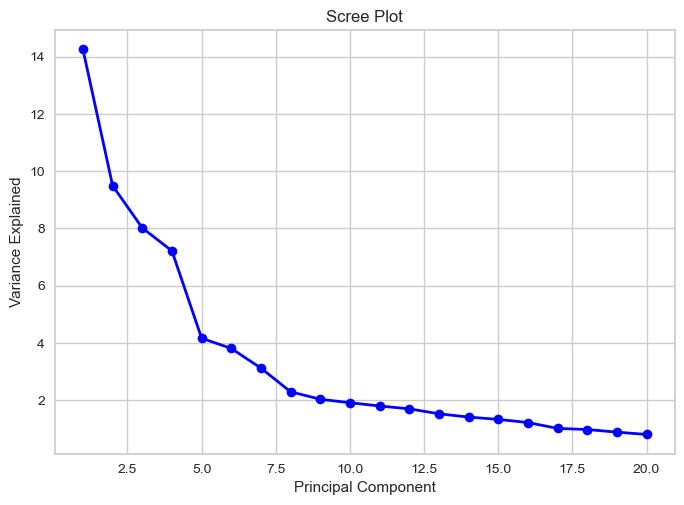

In [70]:
# olhando para eigenvalues e scree plot, decidiu-se optar por usar eigenvalues superior a 1 para o PCA
# poderia ter sido utilizado outro método, como o elbow method, mas este é mais simples e intuitivo e garante mais de 80% da variância explicada

PC_values = np.arange(pca.n_components) + 1
plt.plot(PC_values, pca.explained_variance_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [71]:
# PCA para os indicadores de habitação
pca = PCA(n_components=17)

principalComponents = pca.fit_transform(X_pca)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4','PCA_5', 'PCA_6', 'PCA_7',
                                                                  'PCA_8','PCA_9','PCA_10','PCA_11','PCA_12','PCA_13','PCA_14',
                                                                  'PCA_15','PCA_16','PCA_17'])

In [72]:
loadings = pd.DataFrame(pca.components_.T, columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4','PCA_5', 'PCA_6', 'PCA_7',
                                                                  'PCA_8','PCA_9','PCA_10','PCA_11','PCA_12','PCA_13','PCA_14',
                                                                  'PCA_15','PCA_16','PCA_17'], index=X_pca.columns)

In [73]:
bgri_cluster_LP.reset_index(inplace=True, drop=True)

In [74]:
principalDf.shape

(74, 17)

In [75]:
# Concatenar os dados
bgri_cluster_LP=pd.concat([bgri_cluster_LP,principalDf],axis=1)

In [76]:
bgri_cluster_LP.shape

(74, 96)

In [77]:
bgri_cluster_LP.drop(columns=['FR11','LUG11'], inplace=True)

In [78]:
bgri_cluster_LP

,Cluster_LP,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17
0,3,-0.393329,-0.865521,-0.214630,-0.969454,1.018999,-0.267968,-0.394444,0.468912,-0.501597,...,0.208389,1.190165,0.447181,0.710914,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741
1,5,0.691478,0.380595,0.077999,0.866193,-0.866331,0.022020,0.715172,-0.725670,-0.100478,...,0.065373,-0.485650,-0.103237,-0.558457,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292
2,13,0.479807,0.186018,-0.304785,0.262981,-0.439076,0.874000,0.599823,-0.751932,1.078000,...,-0.918500,0.029962,0.232993,1.949032,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229
3,14,-0.957641,2.303270,-0.960142,-0.443252,0.495429,-0.267968,0.500123,-0.454283,-0.501597,...,0.964531,-0.407824,1.979908,0.322562,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771
4,18,-0.867208,-0.865521,-0.446215,-1.575987,1.622500,-0.267968,0.105943,-0.047489,-0.501597,...,-0.083818,1.907528,1.337072,1.111018,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,162,0.243024,-0.865521,-0.960142,-1.031291,1.080528,-0.267968,-0.469582,0.546454,-0.501597,...,1.322454,-2.857545,4.195808,1.195298,1.398361,-3.255258,-1.380270,1.105656,-2.363612,1.082044
70,163,0.102588,0.693658,-0.071697,0.388838,-0.355413,-0.155084,0.547112,-0.531654,-0.267380,...,-1.238718,-0.033286,0.367812,-0.119151,0.062484,1.339482,1.697195,-0.777830,-0.277867,-0.442309
71,164,0.211207,-0.004260,0.415328,0.527012,-0.553046,0.141237,0.375720,-0.325899,-0.501597,...,-0.579794,-0.392792,0.544616,0.134139,0.457399,0.275628,0.399598,-1.049330,0.416428,1.112774
72,165,-1.029681,-0.865521,-0.960142,-2.144365,2.188035,-0.267968,-1.822065,1.663066,1.762492,...,-0.214503,-0.862327,-0.947895,1.587068,-2.026533,0.098323,-0.127770,1.007143,-0.150903,0.246267


#### 2.2.a PCA Loadings

In [79]:
# view loadings for first principal component group
loadings

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17
PER_EDIFICIOS_CLASSICOS_ISOLADOS,-0.036476,-0.170562,0.137566,0.111238,-0.005767,0.096253,0.090362,0.027287,-0.167472,-0.235216,0.103296,0.088790,-0.073853,0.095591,-0.143777,-0.181387,0.230984
PER_EDIFICIOS_CLASSICOS_GEMIN,0.019508,-0.140627,0.028491,0.038837,0.060070,-0.053129,0.349600,0.021449,0.067900,0.119207,-0.010791,0.000858,0.049495,-0.108510,0.005154,0.116123,-0.309066
PER_EDIFICIOS_CLASSICOS_EMBANDA,0.070364,-0.031898,-0.013176,-0.090517,0.227880,-0.029380,-0.351724,-0.068035,0.141688,0.083224,-0.153389,-0.075312,0.038558,0.001323,0.033112,0.075452,-0.107285
PER_EDIFICIOS_CLASSICOS_1OU2,0.036548,-0.248325,0.124112,0.042282,0.215028,0.032346,-0.031987,-0.021480,0.006159,-0.075058,-0.042469,0.015629,-0.007021,0.028604,-0.095614,-0.036021,-0.046748
PER_EDIFICIOS_CLASSICOS_3OUMAIS,-0.054205,0.241671,-0.097705,-0.102454,-0.210008,-0.037441,0.032697,0.032321,-0.005789,0.046467,0.052972,-0.002521,-0.008328,-0.027850,0.103370,0.031181,0.025164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PER_IND_RESID_EMPREG_SECT_PRIM,-0.050535,-0.070390,0.018494,0.038757,0.054502,-0.044960,-0.100391,-0.191079,0.155056,-0.120151,-0.024238,-0.105556,-0.143046,-0.048145,-0.134594,0.407232,0.487398
PER_IND_RESID_EMPREG_SECT_SEQ,-0.170012,-0.045305,-0.073231,-0.047349,0.080226,0.073116,-0.144081,0.040531,-0.050043,-0.063800,0.132561,0.225298,-0.015154,-0.002815,-0.022155,0.281230,0.105355
PER_IND_RESID_EMPREG_SECT_TERC,-0.111994,0.175977,0.104092,0.084335,0.098497,0.060108,0.134667,0.093005,0.095575,0.089259,-0.198012,-0.171198,0.019551,0.023712,0.045504,-0.044113,-0.005370
PER_IND_RESID_ESTUD_MUN_RESID,-0.227901,0.033619,-0.093429,-0.015946,0.060820,-0.005511,-0.104125,-0.021267,0.081020,0.014116,-0.027044,-0.038276,0.022535,-0.130925,-0.029183,-0.075040,0.009702


### 2.3 Dentrogram (socioeconomic variables)

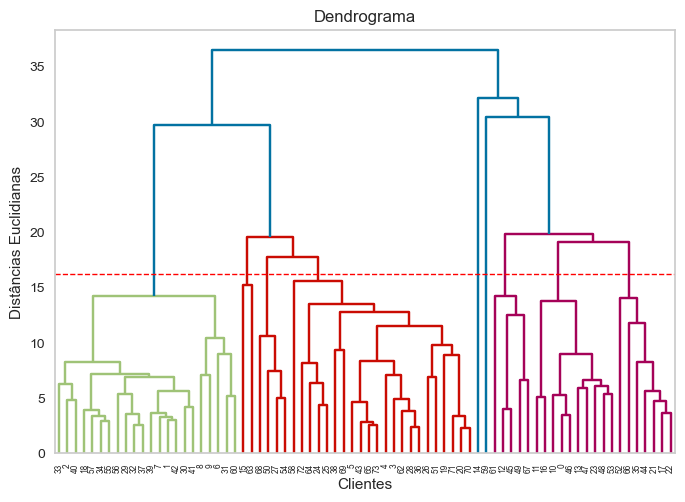

In [80]:
# calculo do dendrograma com método ward
dendrogram = sch.dendrogram(sch.linkage(bgri_cluster_LP[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4','PCA_5', 'PCA_6', 'PCA_7',
                                                                  'PCA_8','PCA_9','PCA_10','PCA_11','PCA_12','PCA_13','PCA_14',
                                                                  'PCA_15','PCA_16','PCA_17']], method  = 'ward'))
plt.title('Dendrograma')
plt.xlabel('Clientes')
plt.ylabel('Distâncias Euclidianas')
plt.axhline(16.2, color='red', linestyle='--', linewidth=1)
plt.grid(False)
plt.show()

In [81]:
# number of clusters suggested by the dendrogram
n_clusters=9

## 3. Clustering

### 3.1 Ward Linkage

In [82]:
# Agglomerative Clustering, no contiguity matrix, ward linkage
hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage ='ward')

In [83]:
y_hc=hc.fit_predict(bgri_cluster_LP)

/Users/andresilvalima/miniforge3/envs/Thesis/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [84]:
# write labels in our dataframe
bgri_cluster_LP['Zona_Ward']=y_hc.T

In [85]:
bgri_cluster_LP.head()

,Cluster_LP,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward
0,3,-0.393329,-0.865521,-0.214630,-0.969454,1.018999,-0.267968,-0.394444,0.468912,-0.501597,...,1.190165,0.447181,0.710914,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741,2
1,5,0.691478,0.380595,0.077999,0.866193,-0.866331,0.022020,0.715172,-0.725670,-0.100478,...,-0.485650,-0.103237,-0.558457,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292,2
2,13,0.479807,0.186018,-0.304785,0.262981,-0.439076,0.874000,0.599823,-0.751932,1.078000,...,0.029962,0.232993,1.949032,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229,2
3,14,-0.957641,2.303270,-0.960142,-0.443252,0.495429,-0.267968,0.500123,-0.454283,-0.501597,...,-0.407824,1.979908,0.322562,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771,2
4,18,-0.867208,-0.865521,-0.446215,-1.575987,1.622500,-0.267968,0.105943,-0.047489,-0.501597,...,1.907528,1.337072,1.111018,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481,2


In [86]:
# prepare data for merging
bgri_cluster2=bgri_cluster_LP.iloc[:,-18:]

In [87]:
bgri_cluster2

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward
0,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,0.208389,1.190165,0.447181,0.710914,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741,2
1,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,0.065373,-0.485650,-0.103237,-0.558457,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292,2
2,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,-0.918500,0.029962,0.232993,1.949032,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229,2
3,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,0.964531,-0.407824,1.979908,0.322562,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771,2
4,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,-0.083818,1.907528,1.337072,1.111018,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,-6.728321,0.413477,-0.835368,-0.442316,-0.815022,0.848234,-0.162988,1.322454,-2.857545,4.195808,1.195298,1.398361,-3.255258,-1.380270,1.105656,-2.363612,1.082044,0
70,-4.137095,0.043969,0.110018,0.602300,2.448445,0.317573,1.674399,-1.238718,-0.033286,0.367812,-0.119151,0.062484,1.339482,1.697195,-0.777830,-0.277867,-0.442309,0
71,-3.337778,-1.051667,0.181803,0.576870,1.780469,0.240333,0.139575,-0.579794,-0.392792,0.544616,0.134139,0.457399,0.275628,0.399598,-1.049330,0.416428,1.112774,0
72,-3.693859,6.050354,-1.535595,-0.698422,0.395763,-1.177519,2.540871,-0.214503,-0.862327,-0.947895,1.587068,-2.026533,0.098323,-0.127770,1.007143,-0.150903,0.246267,0


In [88]:
# prepare data for merging
bgri_cluster3=bgri_cluster_LP.iloc[:,:1]

In [89]:
bgri_cluster3

,Cluster_LP
0,3
1,5
2,13
3,14
4,18
...,...
69,162
70,163
71,164
72,165


In [90]:
# concatenate dataframes
bgri_cluster_LP=pd.concat([bgri_cluster2,bgri_cluster3],axis=1)

In [91]:
bgri_cluster_LP.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward,Cluster_LP
0,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,0.208389,1.190165,0.447181,0.710914,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741,2,3
1,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,0.065373,-0.485650,-0.103237,-0.558457,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292,2,5
2,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,-0.918500,0.029962,0.232993,1.949032,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229,2,13
3,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,0.964531,-0.407824,1.979908,0.322562,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771,2,14
4,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,-0.083818,1.907528,1.337072,1.111018,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481,2,18


In [92]:
# merge relevant data (resulting from the PCA) with the cluster dataframe
clusters_lp=clusters_lp.merge(bgri_cluster_LP,how='left',on='Cluster_LP')

In [93]:
clusters_lp.head()

,Cluster_LP,geometry,area,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,...,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward
0,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,...,1.190165,0.447181,0.710914,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741,2
1,5,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,...,-0.485650,-0.103237,-0.558457,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292,2
2,13,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,...,0.029962,0.232993,1.949032,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229,2
3,14,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,...,-0.407824,1.979908,0.322562,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771,2
4,18,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,...,1.907528,1.337072,1.111018,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481,2


In [94]:
clusters_lp.shape

(74, 21)

In [95]:
# remove the column with the cluster Zona Ward labels
bgri_cluster_LP.drop(['Zona_Ward'],axis=1,inplace=True)

Text(0.5, 1.0, 'Clusterização - Ward Linkage. Clusters = 9')

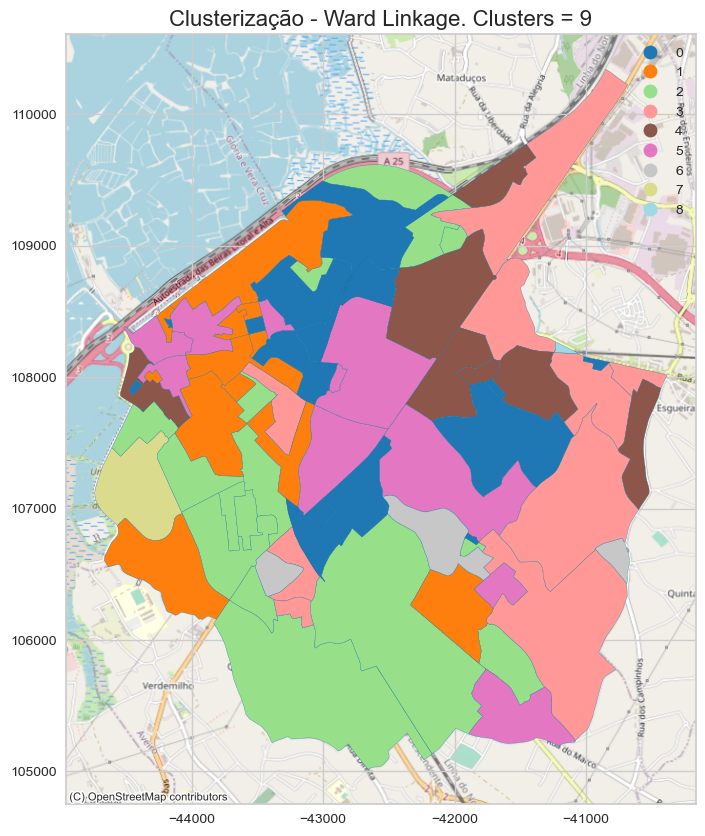

In [96]:
# print the result from the clustering done above
ax=clusters_lp.plot(figsize=(10, 10), column="Zona_Ward", categorical=True, edgecolor="b", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=clusters_lp.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clusterização - Ward Linkage. Clusters = {}'.format(n_clusters), fontsize=16)

### 3.2 Ward Linkage + Queen Contiguity

In [97]:
# Contiguity matrix Queen
RANDOM_SEED = 123456

wqueen = Queen.from_dataframe(clusters_lp)


/var/folders/b2/h8wbjqtd1hl1qwb1wvp4t9lr0000gn/T/ipykernel_3560/113664742.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wqueen = Queen.from_dataframe(clusters_lp)


In [98]:
# Contiguity matrix Queen (arry like)
df  = pd.DataFrame(*wqueen.full()).astype(int)

arr = df.to_numpy()

arr2d = np.transpose(arr)

In [99]:
wqueen.set_transform('R')

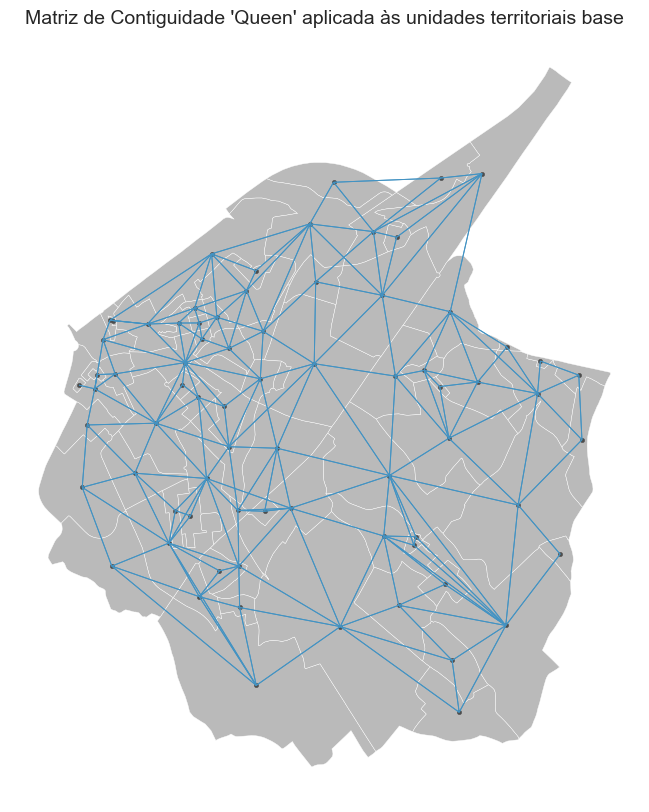

In [100]:
plot_queen=plot_spatial_weights(wqueen, clusters_lp)
plt.title("Matriz de Contiguidade 'Queen' aplicada às unidades territoriais base", fontsize=14)
plt.show()

In [101]:
# Vamos repetir o processo para o método de Ward matriz de contiguidade

hc2 = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage ='ward',connectivity=arr2d)
y_hc2=hc2.fit_predict(bgri_cluster_LP)
clusters_lp['Zona_Ward_Queen']=y_hc2.T

/Users/andresilvalima/miniforge3/envs/Thesis/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [102]:
clusters_lp.head()

,Cluster_LP,geometry,area,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,...,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward,Zona_Ward_Queen
0,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,...,0.447181,0.710914,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741,2,0
1,5,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,...,-0.103237,-0.558457,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292,2,0
2,13,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,...,0.232993,1.949032,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229,2,0
3,14,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,...,1.979908,0.322562,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771,2,0
4,18,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,...,1.337072,1.111018,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481,2,0


Text(0.5, 1.0, 'Clusterização - Ward Linkage. Matriz contiguidade Queen. Clusters = 9')

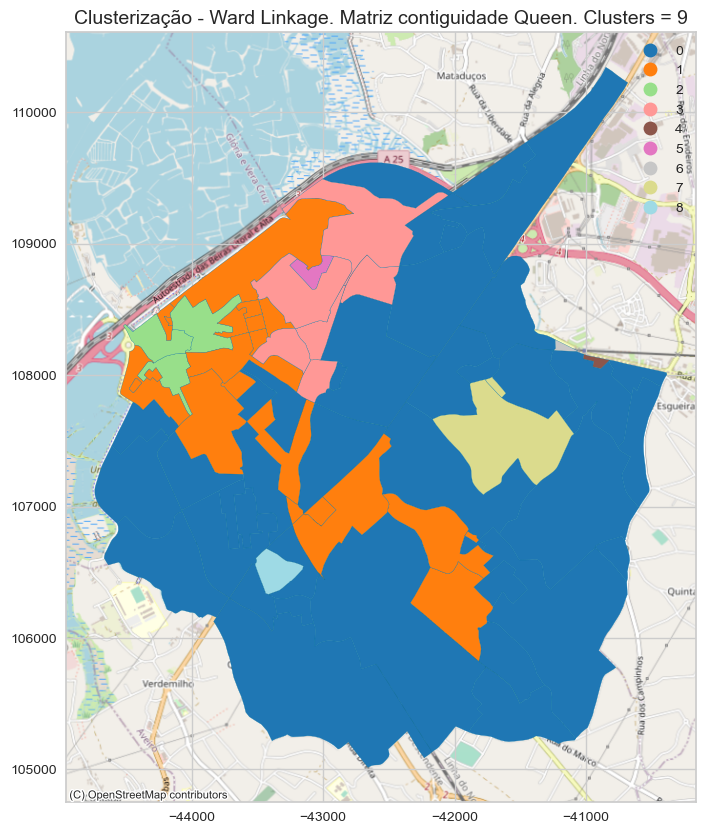

In [103]:
# print the result from the clustering done above
ax=clusters_lp.plot(figsize=(10, 10), column="Zona_Ward_Queen", categorical=True, edgecolor="b", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=clusters_lp.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clusterização - Ward Linkage. Matriz contiguidade Queen. Clusters = {}'.format(n_clusters), fontsize=14)


### 3.3 Max-P Regionalization

https://www.tandfonline.com/doi/full/10.1080/13658816.2020.1759806

https://www.youtube.com/watch?v=HFVKHej1EOc&ab_channel=GeoDaSoftware

https://pysal.org/spopt/generated/spopt.region.MaxPHeuristic.html#spopt.region.MaxPHeuristic

https://pysal.org/spopt/notebooks/maxp.html

É necessário definir a lista de atributos, matriz de pesos espaciais, threshold, threshold_name e o top_n.

In [104]:
# load data (pickle) casasapo
casasapo = pd.read_pickle('../Data/piclo_casasapo.piclo')

# load data (pickle) py
py = pd.read_pickle('../Data/piclo_py.piclo')

In [105]:
# definition of seed
RANDOM_SEED=123456

In [106]:
casasapo['a']=1
py['a']=1

In [107]:
casasapo['Cluster_LP']=casasapo['Cluster_LP'].astype('Int64')

In [108]:
# preparation to calculate the number of dwellings per cluster
df_subtotal_cs = pd.DataFrame()
df_subtotal_py = pd.DataFrame()
df_subtotal_cs = casasapo.groupby('Cluster_LP', as_index=False)[['a']].agg('sum')
df_subtotal_py = py.groupby('Cluster_LP', as_index=False)[['a']].agg('sum')

In [109]:
# merge with clusters_lp dataframe
clusters_lp=clusters_lp.merge(df_subtotal_cs[['Cluster_LP','a']],how='left',on='Cluster_LP')
clusters_lp=clusters_lp.merge(df_subtotal_py[['Cluster_LP','a']],how='left',on='Cluster_LP')

In [110]:
# drop column 'a'
casasapo.drop(columns=['a'],inplace=True)
py.drop(columns=['a'],inplace=True)

In [111]:
# rename columns
clusters_lp.rename(columns={'a_x':'tot_cs','a_y':'tot_py'},inplace=True)

In [112]:
clusters_lp.head()

,Cluster_LP,geometry,area,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,...,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward,Zona_Ward_Queen,tot_cs,tot_py
0,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,...,-1.597396,2.210293,0.531410,1.450034,-0.386257,1.656741,2,0,67.0,4.0
1,5,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,...,-0.361007,0.465900,0.396454,-0.506045,0.568285,0.452292,2,0,146.0,33.0
2,13,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,...,-1.149430,1.436670,1.014228,0.593985,0.249789,1.005229,2,0,78.0,4.0
3,14,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,...,-1.662762,1.249419,-1.579674,-0.404179,0.496831,-0.754771,2,0,65.0,6.0
4,18,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,...,-2.593630,2.428777,-0.130919,1.730948,-0.180224,0.405481,2,0,195.0,8.0


In [113]:
clusters_lp[['tot_cs','tot_py']].describe()

,tot_cs,tot_py
count,60.000000,57.000000
mean,63.216667,14.438596
std,129.702671,27.005963
min,1.000000,1.000000
25%,2.000000,3.000000
50%,10.000000,6.000000
75%,75.750000,15.000000
max,770.000000,185.000000


In [114]:
# define the minimum number of dwellings per cluster, pre and post intervention (casasapo and py)
clusters_lp['tot_min']=clusters_lp[['tot_cs','tot_py']].min(axis=1)

In [115]:
attrs_name = list(clusters_lp[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4','PCA_5', 'PCA_6', 'PCA_7',
                                                                  'PCA_8','PCA_9','PCA_10','PCA_11','PCA_12','PCA_13','PCA_14',
                                                                  'PCA_15','PCA_16','PCA_17']])

In [116]:
# minimum number of dwellings per cluster
threshold = 102

In [117]:
# The number of top candidate regions to consider for enclave assignment.
top_n = 3

In [118]:
# criteria for the alghoritm - number of dwellings per cluster
threshold_name='tot_min'

In [119]:
# model with MaxP
np.random.seed(RANDOM_SEED)
model_maxp = MaxP(clusters_lp, wqueen, attrs_name, threshold_name, threshold, top_n)
model_maxp.solve()

In [120]:
clusters_lp["Zona_Maxp"] = model_maxp.labels_

In [121]:
clusters_lp[["Zona_Maxp"]].groupby(by="Zona_Maxp").count()

""
Zona_Maxp
1
2
3
4
5
6
7
8
9


In [122]:
a=model_maxp.p
a

9

Text(0.5, 1.0, 'Clusterização - Max-P. Threshold = 102 imóveis. Clusters = 9')

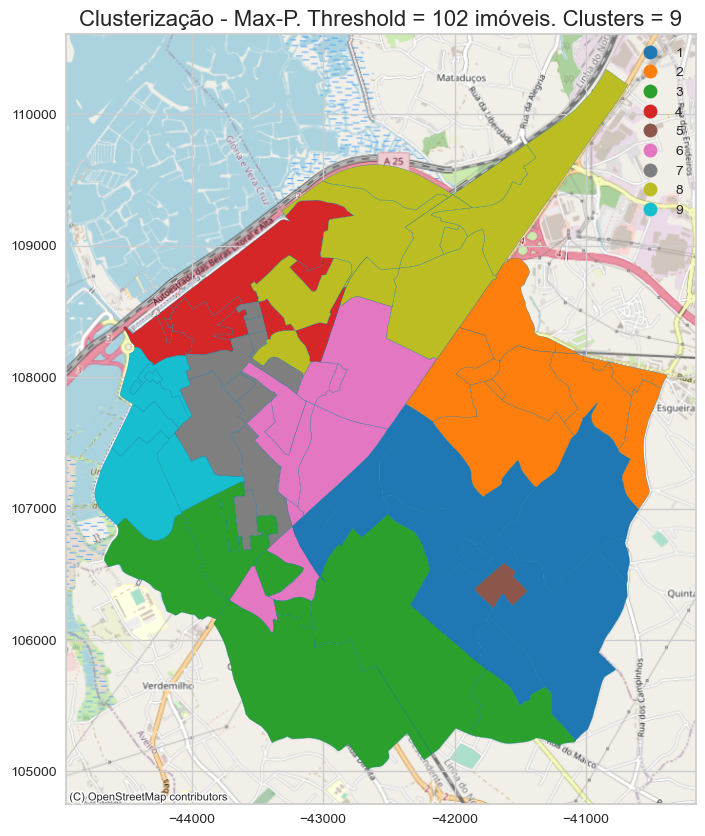

In [123]:
# result from the Max-P Regionalization
ax=clusters_lp.plot(figsize=(10, 10), column="Zona_Maxp", categorical=True, edgecolor="b", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=clusters_lp.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clusterização - Max-P. Threshold = %s imóveis. Clusters = %s' % (threshold, a), fontsize=16)

In [124]:
clusters_lp.head()

,Cluster_LP,geometry,area,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,...,PCA_14,PCA_15,PCA_16,PCA_17,Zona_Ward,Zona_Ward_Queen,tot_cs,tot_py,tot_min,Zona_Maxp
0,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,...,0.531410,1.450034,-0.386257,1.656741,2,0,67.0,4.0,4.0,6
1,5,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,...,0.396454,-0.506045,0.568285,0.452292,2,0,146.0,33.0,33.0,3
2,13,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,...,1.014228,0.593985,0.249789,1.005229,2,0,78.0,4.0,4.0,1
3,14,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,...,-1.579674,-0.404179,0.496831,-0.754771,2,0,65.0,6.0,6.0,8
4,18,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,...,-0.130919,1.730948,-0.180224,0.405481,2,0,195.0,8.0,8.0,8


### 3.4 SKATER (Spatial ’K’luster Analysis by Tree Edge Removal)

https://www.tandfonline.com/doi/full/10.1080/13658810600665111

https://pysal.org/spopt/notebooks/skater.html

https://pysal.org/spopt/generated/spopt.region.Skater.html#spopt.region.Skater

https://www.dshkol.com/post/spatially-constrained-clustering-and-regionalization/

In [125]:
# minimum number of zones per cluster
floor = 3

In [126]:
# Flag denoting whether to store intermediate labelings as the tree gets pruned. (default False)
trace = False

In [127]:
# Description of what to do with islands. If 'ignore', the algorithm will discover n_clusters regions, treating islands as their own regions.
# If “increase”, the algorithm will discover n_clusters regions, treating islands as separate from n_clusters. (default ‘increase’)
islands = "increase"

In [128]:
# standard definition for the spannig tree algorithm
default = dict(dissimilarity=skm.manhattan_distances,affinity=None,reduction=np.sum,center=np.mean,verbose=False)


In [129]:
# model using the skater algorithm
model_skater = spopt.region.Skater(clusters_lp,wqueen,attrs_name,n_clusters=n_clusters,floor=floor,trace=trace,islands=islands,spanning_forest_kwds=default)
model_skater.solve()

In [130]:
# write skater cluster info
clusters_lp["Zona_SKATER"] = model_skater.labels_

In [131]:
# resulting number of clusters, for the graph title
temp=len(clusters_lp["Zona_SKATER"].unique())
temp

9

Text(0.5, 1.0, 'Clusterização - SKATER. Clusters = 9')

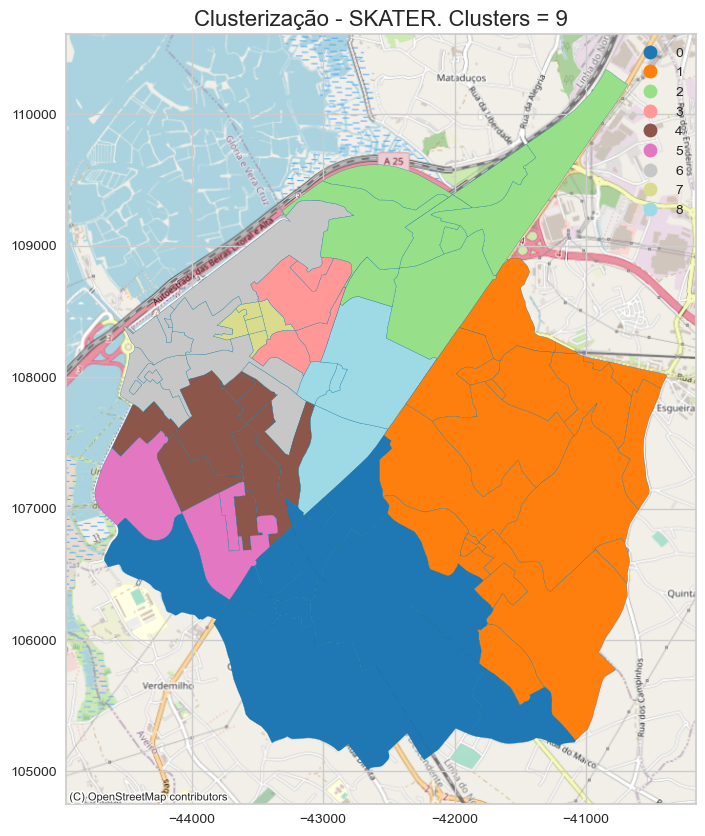

In [132]:
# result of the SKATER Regionalization
ax=clusters_lp.plot(figsize=(10, 10), column="Zona_SKATER", categorical=True, edgecolor="b", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=clusters_lp.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clusterização - SKATER. Clusters = {}'.format(temp), fontsize=16)

# 4. Export Data to Pickle Files

In [133]:
# save data (pickle) bgri
bgri_cluster.to_pickle('../Data/piclo_bgri_2.piclo')

In [134]:
# save data (pickle) clusters
clusters_lp.to_pickle('../Data/piclo_clusters_2.piclo')

# 5. Cluster Metrics

Neste Link podem ser encontrados os métodos de avaliação de clusterização:
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation 


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

https://journals.sagepub.com/doi/10.1177/2399808319875752

https://pysal.org/esda/notebooks/geosilhouettes.html

https://www.scikit-yb.org/en/latest/index.html

In [135]:
x_val = clusters_lp[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4','PCA_5', 'PCA_6', 'PCA_7','PCA_8','PCA_9','PCA_10',
                     'PCA_11','PCA_12','PCA_13','PCA_14','PCA_15','PCA_16','PCA_17']]

In [136]:
clusters_lp.head()

,Cluster_LP,geometry,area,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,...,PCA_15,PCA_16,PCA_17,Zona_Ward,Zona_Ward_Queen,tot_cs,tot_py,tot_min,Zona_Maxp,Zona_SKATER
0,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,1.859242,1.473328,0.503675,-1.493861,-2.261176,0.663504,0.458857,...,1.450034,-0.386257,1.656741,2,0,67.0,4.0,4.0,6,0
1,5,"POLYGON ((-43286.789 105259.255, -43301.335 10...",0.141979,-0.518778,-2.030999,0.390880,-0.232010,1.092900,0.990312,0.233503,...,-0.506045,0.568285,0.452292,2,0,146.0,33.0,33.0,3,0
2,13,"POLYGON ((-41736.204 106118.443, -41725.968 10...",0.156570,-2.479043,-2.370166,-0.932093,1.847863,-0.764976,-0.001265,-0.222427,...,0.593985,0.249789,1.005229,2,0,78.0,4.0,4.0,1,1
3,14,"POLYGON ((-41919.284 109040.306, -41921.584 10...",0.018652,-1.324850,-1.566229,0.398728,-0.850436,-1.152174,-0.389745,0.038005,...,-0.404179,0.496831,-0.754771,2,0,65.0,6.0,6.0,8,2
4,18,"POLYGON ((-42101.612 108979.483, -42098.652 10...",0.009896,-2.462028,0.713486,-0.206446,-1.298509,-2.872488,0.961881,1.048422,...,1.730948,-0.180224,0.405481,2,0,195.0,8.0,8.0,8,2


## 5.1 - Metrics - Ward Linkage

In [137]:
score_ward = silhouette_score(x_val, clusters_lp.Zona_Ward, metric='manhattan')

In [138]:
silhouettes_ward = silhouette_samples(x_val, clusters_lp.Zona_Ward)

## 5.2 - Metrics - Ward Linkage + Queen Contiguity

In [139]:
score_ward_queen = silhouette_score(x_val, clusters_lp.Zona_Ward_Queen, metric='manhattan')

In [140]:
silhouettes_ward_queen = silhouette_samples(x_val, clusters_lp.Zona_Ward_Queen)

## 5.3 - Metrics - Max-P Regionalization

In [141]:
score_maxp = silhouette_score(x_val, clusters_lp.Zona_Maxp, metric='manhattan')

In [142]:
silhouettes_maxp = silhouette_samples(x_val, clusters_lp.Zona_Maxp)

## 5.4 - Metrics - SKATER (Spatial ’K’luster Analysis by Tree Edge Removal)

In [143]:
score_skater = silhouette_score(x_val, clusters_lp.Zona_SKATER, metric='manhattan')

In [144]:
silhouettes_skater = silhouette_samples(x_val, clusters_lp.Zona_SKATER)

## 5.5 - Metrics - Clustering - Comparison

### 5.5.1 - Comparison - Silhouette Score (average) - Sklearn

In [145]:
score=[score_ward,score_ward_queen,score_maxp,score_skater]
method=['Ward','Ward Queen','Max-P','SKATER']

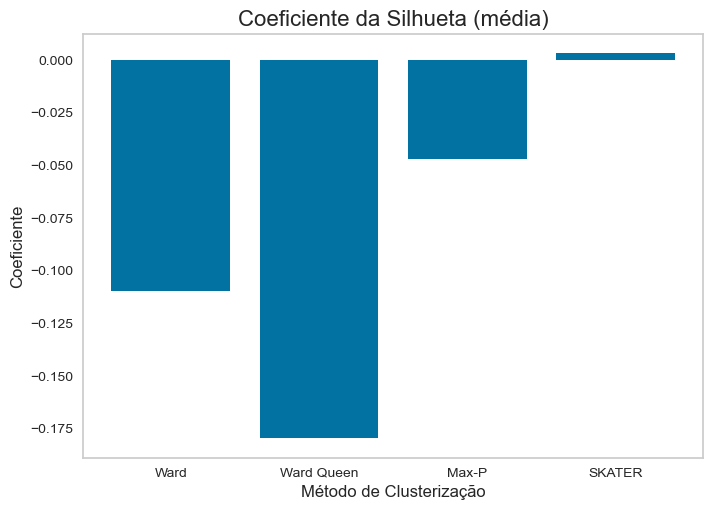

In [146]:
# Plot dos histogramas das silhuetas para cada clusterização (média), para cada método de clusterização

plt.bar(method, score)
plt.xlabel('Método de Clusterização', fontsize = 12)
plt.ylabel('Coeficiente', fontsize = 12)
plt.title('Coeficiente da Silhueta (média)', fontsize = 16)
plt.grid(False)
plt.show()

### 5.5.2 - Comparison - Silhouette Score (Samples) - Sklearn

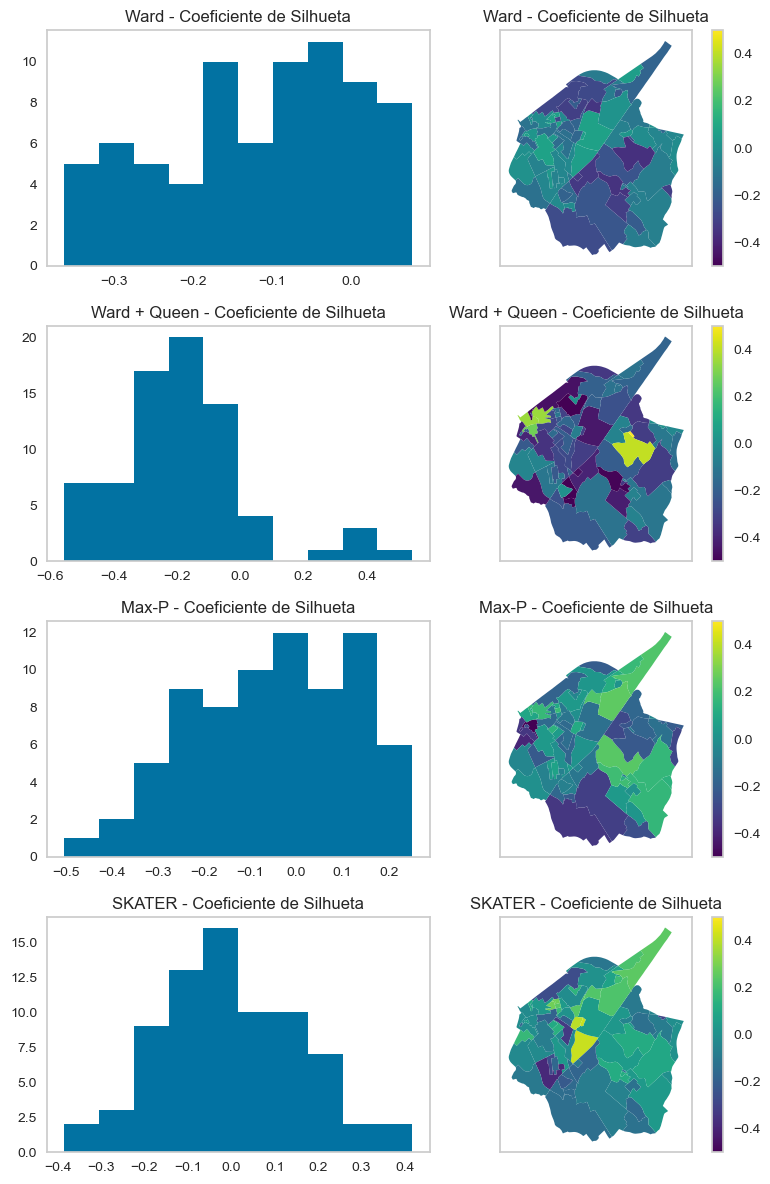

In [147]:
# Plot dos histogramas das silhuetas para cada cluster, para cada método de clusterização, com a média de cada cluster

f,ax = plt.subplots(4,2,figsize=(8,12))
ax[0,0].hist(silhouettes_ward)
clusters_lp.plot(silhouettes_ward, ax=ax[0,1], cmap='viridis',vmin=-.5, vmax=.5,legend=True)
ax[1,0].hist(silhouettes_ward_queen)
clusters_lp.plot(silhouettes_ward_queen, ax=ax[1,1], cmap='viridis',vmin=-.5, vmax=.5,legend=True)
ax[2,0].hist(silhouettes_maxp)
clusters_lp.plot(silhouettes_maxp, ax=ax[2,1], cmap='viridis',vmin=-.5, vmax=.5,legend=True)
ax[3,0].hist(silhouettes_skater)
clusters_lp.plot(silhouettes_skater, ax=ax[3,1], cmap='viridis',vmin=-.5, vmax=.5,legend=True)
ax[0,0].set_title("Ward - Coeficiente de Silhueta")
ax[0,0].grid(False)
ax[0,1].set_title("Ward - Coeficiente de Silhueta")
ax[0,1].axes.get_xaxis().set_visible(False)
ax[0,1].axes.get_yaxis().set_visible(False)
ax[1,0].set_title("Ward + Queen - Coeficiente de Silhueta")
ax[1,0].grid(False)
ax[1,1].set_title("Ward + Queen - Coeficiente de Silhueta")
ax[1,1].axes.get_xaxis().set_visible(False)
ax[1,1].axes.get_yaxis().set_visible(False)
ax[2,0].set_title("Max-P - Coeficiente de Silhueta")
ax[2,0].grid(False)
ax[2,1].set_title("Max-P - Coeficiente de Silhueta")
ax[2,1].axes.get_xaxis().set_visible(False)
ax[2,1].axes.get_yaxis().set_visible(False)
ax[3,0].set_title("SKATER - Coeficiente de Silhueta")
ax[3,0].grid(False)
ax[3,1].set_title("SKATER - Coeficiente de Silhueta")
ax[3,1].axes.get_xaxis().set_visible(False)
ax[3,1].axes.get_yaxis().set_visible(False)
f.tight_layout()
plt.show()
